In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.integrate import odeint
from IPython.display import Image
from statistics import mode
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
import pingouin as pg

# Suppress warnings
warnings.filterwarnings('ignore')

# Set number of decimals for np print options
np.set_printoptions(precision=3)

# Set the current working directory
os.chdir(sys.path[0])

In [3]:
df = pd.read_csv('partial_correlation_data_annual.csv')
df.head()

,year,P,S,E
0,1980,1003,3276,1260
1,1981,346,170,1395
2,1982,944,860,1208
3,1983,1111,2500,1190
4,1984,454,189,1313


In [7]:
from sklearn.linear_model import LinearRegression
x = df['S'].values.reshape(-1, 1)
y = df['P'].values.reshape(-1, 1)

# fit the model to the data
model = LinearRegression()
model.fit(x, y)

y_est = model.predict(x)

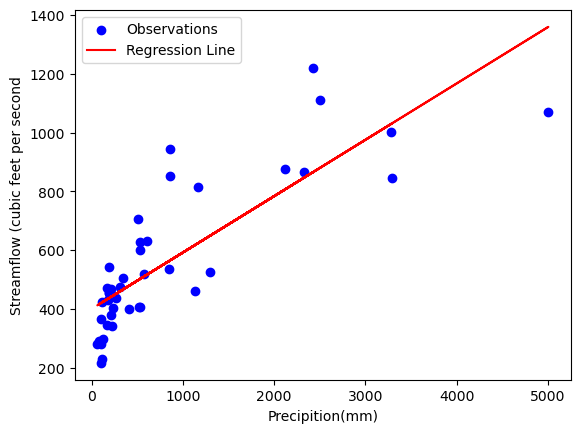

In [12]:
plt.scatter(x, y, c = 'blue', label = "Observations")
plt.plot(x, y_est, c = 'red', linestyle = '-', label = "Regression Line")
plt.xlabel('Precipition(mm)')
plt.ylabel('Streamflow (cubic feet per second')
plt.legend()
plt.title('')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y, y_est)
r2 = r2_score(y, y_est)

print("Mean Squared Error:", np.round(mse, 2))
print("R-squared:", np.round(r2, 2))

Mean Squared Error: 21390.6
R-squared: 0.67


In [18]:
df = pd.read_csv('monthly_meteo_streamflow.csv')
df

,year,month,P,E,Tmean,Tmax,Tmin,Tdmean,vpdmax,vpdmin,S
0,1980,1,336.051600,19.272449,4.622550,8.745250,0.500800,-3.860550,6.400100,1.616000,423.612903
1,1980,2,418.161899,29.872766,5.514000,10.940600,0.088350,-5.081450,8.782650,1.898050,1685.965517
2,1980,3,154.332850,58.054099,4.030850,9.760900,-1.698250,-5.708050,8.087550,1.454300,609.161290
3,1980,4,19.936850,115.392255,8.772800,16.275450,1.271500,-5.285750,15.164100,2.414800,236.533333
4,1980,5,26.090900,116.888575,8.761500,15.231000,2.293150,0.081100,11.650450,1.135850,174.290323
...,...,...,...,...,...,...,...,...,...,...,...
499,2021,8,3.187385,152.323303,21.948775,27.692679,16.205010,4.492985,29.707269,9.432910,0.425161
500,2021,9,0.694000,112.327974,19.826580,25.139330,14.513980,1.894015,26.081899,7.880130,0.536333
501,2021,10,34.804679,80.789519,10.903875,17.622540,4.185345,-2.362750,13.043130,3.043920,1.584839
502,2021,11,0.000000,50.394858,11.795860,16.642759,6.949110,-6.681535,15.416895,5.452640,2.848667


In [19]:
x1 = df.iloc[:,2:-1]
x1

,P,E,Tmean,Tmax,Tmin,Tdmean,vpdmax,vpdmin
0,336.051600,19.272449,4.622550,8.745250,0.500800,-3.860550,6.400100,1.616000
1,418.161899,29.872766,5.514000,10.940600,0.088350,-5.081450,8.782650,1.898050
2,154.332850,58.054099,4.030850,9.760900,-1.698250,-5.708050,8.087550,1.454300
3,19.936850,115.392255,8.772800,16.275450,1.271500,-5.285750,15.164100,2.414800
4,26.090900,116.888575,8.761500,15.231000,2.293150,0.081100,11.650450,1.135850
...,...,...,...,...,...,...,...,...
499,3.187385,152.323303,21.948775,27.692679,16.205010,4.492985,29.707269,9.432910
500,0.694000,112.327974,19.826580,25.139330,14.513980,1.894015,26.081899,7.880130
501,34.804679,80.789519,10.903875,17.622540,4.185345,-2.362750,13.043130,3.043920
502,0.000000,50.394858,11.795860,16.642759,6.949110,-6.681535,15.416895,5.452640


In [20]:
# Convert to a pandas Series
y = pd.Series(df.iloc[:,-1])
y

0       423.612903
1      1685.965517
2       609.161290
3       236.533333
4       174.290323
          ...     
499       0.425161
500       0.536333
501       1.584839
502       2.848667
503     151.384194
Name: S, Length: 504, dtype: float64

In [22]:
def partial_corr(x1, y):
    df_corr = x1.copy()
    df_corr['S'] = y
    partial_corrs = {}

    # compute Partial Correlation
    for feature in x1.columns:
        pcorr = pg.partial_corr(data = df_corr, x = feature, y='S', covar = [col for col in x1.columns if col != feature])
        partial_corrs[feature] = pcorr['r'].values[0]
    
    return pd.Series(partial_corrs)

partial_corr_scores = partial_corr(x1, y)
partial_corr_4features = partial_corr_scores.abs().nlargest(4).index
print("Top 4 most important features based on Partial correlation:", partial_corr_4features.tolist())

Top 4 most important features based on Partial correlation: ['P', 'vpdmax', 'E', 'Tdmean']


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = df['P'].values.reshape(-1, 1)
y = df['S'].values

X_train_1, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model_1 = LinearRegression()
model_1.fit(X_train_1, y_train)

y_pred = model_1.predict(X_test)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model1")
print("Mean Squared Error:", np.round(mse, 2))
print("R-squared:", np.round(r2, 2))

Model1
Mean Squared Error: 13203.6
R-squared: 0.07


In [39]:
X_1 = df[['P', 'vpdmax', 'E', 'Tdmean']].values
y_1 = df['S'].values

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)

y_pred_1 = model_1.predict(X_test_1)
mse = mean_squared_error(y_test, y_pred_1)
r2 = r2_score(y_test, y_pred_1)
print("Model2")
print("Mean Squared Error:", np.round(mse, 2))
print("R-squared:", np.round(r2, 2))

Model2
Mean Squared Error: 12952.24
R-squared: 0.09


In [42]:
X_2 = df[['P', 'E', 'Tmean', 'Tmax', 'Tmin', 'Tdmean', 'vpdmax', 'vpdmin']].values
y_2 = df['S'].values

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)

y_pred_2 = model_2.predict(X_test_2)
mse = mean_squared_error(y_test, y_pred_2)
r2 = r2_score(y_test, y_pred_2)
print("Model3")
print("Mean Squared Error:", np.round(mse, 2))
print("R-squared:", np.round(r2, 2))

Model3
Mean Squared Error: 12738.2
R-squared: 0.1
